#__BERT SENTENCE PAIRS CLASSIFICATION - SNLI DATASET__

 In this notebook we will be implementing BERT for a multi-classification problem. The dataset used for this experiment is the SNLI, which has two pair sentences and a label for every pair. 

 BERT is a recently new neural network architecture that is capable to extract most of the meaning of a given text and it has been applied to multiple tasks in NLU, including sequence classification.  

### 1. SET UP

This model performs lots of operations and it requires to make use of a GPU in order to accelerate the computation time. We also need to download some packages such as the transformers and wget, this way we can use the interface of pytorch to apply BERT and download the data from internet.

In [ ]:
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU not available')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU   
    device = torch.device("cuda")

    print('There are {} GPU(s) available.'.format(torch.cuda.device_count()))

    print('GPU name:', torch.cuda.get_device_name(0))

# If not, use the CPU
else:
    print('GPU not found, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU name: Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 16.5MB/s 
     |████████████████████████████████| 3.0MB 21.1MB/s 
     |████████████████████████████████| 890kB 24.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3c0a2f40b6ca7e0b3c61e9d0f439a82dd6248b3c49d2b437e82edf848ff17d0e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### 2. DATA EXPLORATION

The SNLI dataset has three main columns {sentence1, sentence2 and gold_label}. For every pair of sentences we have a label whether they are an entailment, neutral or a contradiction to one another. 

In [ ]:
# Download the data from the internet
!wget -P /content/project_data/ -c  "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"

--2020-08-25 08:40:37--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘/content/project_data/snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  4.42MB/s    in 29s     

2020-08-25 08:41:06 (3.14 MB/s) - ‘/content/project_data/snli_1.0.zip’ saved [94550081/94550081]



In [ ]:

# Unzip the dataset
!unzip '/content/project_data/snli_1.0.zip'

Archive:  /content/project_data/snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/snli_1.0/
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_test.txt  
  inflating: snli_1.0/snli_1.0_train.jsonl  
  inflating: snli_1.0/snli_1.0_train.txt  
  inflating: __MACOSX/._snli_1.0     


In [ ]:
import pandas as pd

# Create a pandas dataframe
train_df = pd.read_csv("./snli_1.0/snli_1.0_train.txt", delimiter='\t')
train_df = train_df[['sentence1', 'sentence2', 'gold_label']]

# Remove all the rows labeled as '-' and NaN
train_df = train_df.loc[train_df['gold_label'] != '-']
train_df = train_df.dropna()

# Create a subset of the data
train_df = train_df.iloc[:12500,:]

# Check the length of the training set
print('Length of the training set:', len(train_df))

# Display the top 5 rows
train_df.head()

Length of the training set: 12500


,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


BERT needs a certain input string, where two sentences have to be separated by the [SEP] character. It is the only way that the model understands that is processing a sequence of sentences (A and B).

In [ ]:
# Get the vector of sentences and labels
import numpy as np

sentA = train_df.sentence1.values
sentB = train_df.sentence2.values

# Transform string labels into int labels
int_label = {'entailment':0, 'neutral':1, 'contradiction':2}

labels = np.array([int_label[i] for i in train_df.gold_label])

In [ ]:
# Shape of the sentences and labels
print('Shape sentences A:', sentA.shape)
print('Shape sentences B:', sentB.shape)
print('Shape labels:', labels.shape)

Shape sentences A: (12500,)
Shape sentences B: (12500,)
Shape labels: (12500,)


### 3. INPUT REPRESENTATION

### 3.1 Input IDS and Sentence IDS

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer. We will be using the base model of BERT (12 layers)
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Tokenize all the sentences and map the tokens to thier word IDs.
input_ids = []
sent_ids = []

for i in range(0,12500):
    # 'encode' will tokenize every word in the sentence, 
    # Add [CLS] and [SEP] special characters to the beggining and end of the sentence (also add [SEP] between sentA and B)
    # Finally map every token to their ID
    encoded_sent = tokenizer(
                        sentA[i],
                        sentB[i],                   
                        add_special_tokens = True)
    
    sent_ids.append(encoded_sent['token_type_ids'])
    input_ids.append(encoded_sent['input_ids'])

# Example of the first sentence
print('Pair Sentence: {0} {1}'.format(sentA[0],sentB[0]))
print('Sentence IDS:', sent_ids[0])
print('BERT tokens IDs:', input_ids[0])

Pair Sentence: A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.
Sentence IDS: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
BERT tokens IDs: [101, 1037, 2711, 2006, 1037, 3586, 14523, 2058, 1037, 3714, 2091, 13297, 1012, 102, 1037, 2711, 2003, 2731, 2010, 3586, 2005, 1037, 2971, 1012, 102]


### 3.2 Padding

Not all the sentences have the same length. To correct that, we use padding which is adding another special character [PAD] to the end of every sentences, so the length of every vector is the same. 

In [ ]:
# Find the largest sentence in our IDs vector
print('Length of the longest sentence:', max([len(sent) for sent in input_ids]))

Length of the longest sentence: 94


In [ ]:
# All the sentence inputs need to have the same length
# That's why we use padding to put additional tokens [PAD] to those sentences that are shorter than the largest one 
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length. It needs to be larger than 94
max_len = 100

print('Padding all the sentences to:',max_len)

# Set PAD IDs as value=0 for the attention mask
# "post" means that we add those special characters to the end of the sentence
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

# SEt the PAD IDs as 1, as we move them to the back of the sentence
sent_ids = pad_sequences(sent_ids, maxlen=max_len, dtype="long", 
                          value=1, truncating="post", padding="post")

print('Padding completed!')

Padding all the sentences to: 100
Padding completed!


### 3.3 Masked Language Modeling (MLM)

Part of the Pre-Training of BERT is MLM, that is replacing 15% of the tokens by a MASK character. The model will try to predict the right token by its context.

In [ ]:
# Create attention mask vector
att_masks = []

for sent in input_ids:
   
    # This vector will have two possible values [0,1]. All the padding tokens can't be masked, so we need to set them as 0, the rest as 1
    mask = [int(id > 0) for id in sent]
    att_masks.append(mask)

### 3. SPLIT DATASET

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data where 90% is for training and 10% for validation (development)
X_train, X_dev, y_train, y_dev = train_test_split(input_ids, labels, 
                                                            random_state=203, test_size=0.1)
# Same split for the masks vector
masks_train, masks_dev, _, _ = train_test_split(att_masks, labels,
                                             random_state=203, test_size=0.1)

# Same split for the sent_ids vector
sentID_train, sentID_dev, _, _ = train_test_split(sent_ids, labels,
                                             random_state=203, test_size=0.1)

In [ ]:
# Transform the inputs, labels, attention masks and sentence IDs vectors into torch tensors
X_train = torch.tensor(X_train)
X_dev = torch.tensor(X_dev)

y_train = torch.tensor(y_train)
y_dev = torch.tensor(y_dev)

masks_train = torch.tensor(masks_train)
masks_dev = torch.tensor(masks_dev)

sentID_train = torch.tensor(sentID_train)
sentID_dev = torch.tensor(sentID_dev)

In [ ]:
# To save memory during our training process, we use the DataLoader class to create an iterator
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32 # The optimum bacth sizes are 16 or 32

# Create the DataLoader for our training set.
train_data = TensorDataset(X_train, masks_train, sentID_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
dev_data = TensorDataset(X_dev, masks_dev, sentID_dev, y_dev)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

### 4. DATA MODELING

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load the BertForSequenceClassification (model for fine-tuning)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use BERTbase model (12 layers)
    num_labels = 3, # Set the number of classes 
    output_attentions = False,
    output_hidden_states = False)

# Run this model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 4.1 Hiper-Parameters

In [ ]:
# Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning rate (authors recommend: [5e-5, 3e-5, 2e-5])
                  eps = 1e-8)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is the number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
from transformers import get_linear_schedule_with_warmup

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


### 4.2 Training Loop

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
from sklearn.metrics import accuracy_score

# Set the same seed value to make it reproducible
seed_val = 203

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss
loss_values = []

# Loop over the epochs
for epoch_i in range(0, epochs):
    
    # ============= Training Phase =================
    
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('> Training Mode...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for every epoch
    total_loss = 0

    # Let the know the model that is on training mode
    model.train()

    # For each batch in the train set
    for step, batch in enumerate(train_dataloader):

        # Check the progress every 40 batches
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('\tBatch {0}/{1}.\tElapsed: {2}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the training batch from our dataloader. Copy each tensor to the GPU 

        # Each `batch` contains 4 tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: sentence ID
        #   [3]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_sent_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Always reset the gradients before performing a backward pass 
        model.zero_grad()        

        # Perform a forward pass (evaluate the BERT model on this training batch)
        # If we provide the labels, this output will give us the loss of the batch
        outputs = model(b_input_ids, 
                    token_type_ids=b_sent_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # Take the first element of the tuple
        loss = outputs[0]

        # Accumulate the loss of this train batch to compute the average at the end
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient based on their Hyper-parameters (learn rate, gradients and so on)
        optimizer.step()

        # Update the learn rate
        scheduler.step()

    # Calculate the average loss over this train set
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for future plots of the learning curve
    loss_values.append(avg_train_loss)

    print("\n\tAverage training loss: {0:.2f}".format(avg_train_loss))
    print("\tTraining epcoh time: {:}".format(format_time(time.time() - t0)))
        
    # ============= Validation Phase =================

    # Measure the performance on the validation set in every epoch

    print("> Validation Mode...")

    t0 = time.time()

    # Set the model in evaluation mode, because the dropout behaves differently during validation
    model.eval()

    # Track all the variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    ## Save the predictions   
    vec_pred = np.array([])

    # Evaluate data for one epoch
    for batch in dev_dataloader:
      
        # Unpack the development batch from our dataloader. Copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_sent_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
        
        # Tell the model not to compute or store gradients
        with torch.no_grad():        

            # Perform the forward pass. This output will return the predictions, because we haven't specified the labels
            outputs = model(b_input_ids, 
                            token_type_ids=b_sent_ids, # Same as "segment ids", which differentiates sentence 1 and 2 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output, which are the predictions befroe applying the activation function (e.g., softmax)
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        ##
        batch_pred = np.argmax(logits, axis=1).flatten() ## predictions of every batch
        vec_pred = np.append(vec_pred, batch_pred) ## Save the batch predictions in the main vec_pred
        
        # Calculate the accuracy for this batch of test sentences
        tmp_eval_accuracy = accuracy_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten())
        #tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Final accuracy for this validation epoch
    print("\tAccuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("\tValidation epoch time: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 4 ========
> Training Mode...
	Batch 40/352.	Elapsed: 0:00:39.
	Batch 80/352.	Elapsed: 0:01:18.
	Batch 120/352.	Elapsed: 0:01:56.
	Batch 160/352.	Elapsed: 0:02:35.
	Batch 200/352.	Elapsed: 0:03:14.
	Batch 240/352.	Elapsed: 0:03:53.
	Batch 280/352.	Elapsed: 0:04:32.
	Batch 320/352.	Elapsed: 0:05:11.

	Average training loss: 0.74
	Training epcoh time: 0:05:41
> Validation Mode...
	Accuracy: 0.79
	Validation epoch time: 0:00:14

======== Epoch 2 / 4 ========
> Training Mode...
	Batch 40/352.	Elapsed: 0:00:39.
	Batch 80/352.	Elapsed: 0:01:18.
	Batch 120/352.	Elapsed: 0:01:56.
	Batch 160/352.	Elapsed: 0:02:35.
	Batch 200/352.	Elapsed: 0:03:14.
	Batch 240/352.	Elapsed: 0:03:53.
	Batch 280/352.	Elapsed: 0:04:32.
	Batch 320/352.	Elapsed: 0:05:11.

	Average training loss: 0.46
	Training epcoh time: 0:05:41
> Validation Mode...
	Accuracy: 0.82
	Validation epoch time: 0:00:14

======== Epoch 3 / 4 ========
> Training Mode...
	Batch 40/352.	Elapsed: 0:00:39.
	Batch 80/352.	Elap

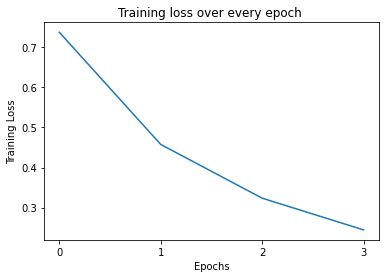

In [ ]:
# Plot the Loss value through the epochs
import matplotlib.pyplot as plt
%matplotlib inline

x = range(0,4)
plt.plot(x, loss_values, '-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.xticks([0,1,2,3])
plt.title('Training loss over every epoch ')
plt.show()

### 5. TEST SET AND ERROR ANALYSIS

In [ ]:
# Create a pandas dataframe
test_df = pd.read_csv("./snli_1.0/snli_1.0_test.txt", delimiter='\t')
test_df = test_df[['sentence1', 'sentence2', 'gold_label']]

# Remove all the rows labeled as '-' and NaN
test_df = test_df.loc[test_df['gold_label'] != '-']
test_df = test_df.dropna()

# Create a subset of the data
test_df = test_df.iloc[:2500,:]

# Check the length of the training set
print('Length of the training set:', len(test_df))

# Display the top 5 rows
test_df.head()

Length of the training set: 2500


,sentence1,sentence2,gold_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment


In [ ]:
# Get the vector of sentences (A and B) and labels
sentA = test_df.sentence1.values
sentB = test_df.sentence2.values

# Transform string labels into int labels
labels = np.array([int_label[i] for i in test_df.gold_label])

In [ ]:
# Shape of the sentences and labels
print('Shape sentences A:', sentA.shape)
print('Shape sentences B:', sentB.shape)
print('Shape labels:', labels.shape)

Shape sentences A: (2500,)
Shape sentences B: (2500,)
Shape labels: (2500,)


In [ ]:

# Tokenize all the sentences and map the tokens to thier word IDs.
input_ids = []
sent_ids = []

for i in range(0,2500):
    # 'encode' will tokenize every word in the sentence, 
    # Add [CLS] and [SEP] special characters to the beggining and end of the sentence (also add [SEP] between sentA and B)
    # Finally map every token to their ID
    encoded_sent = tokenizer(
                        sentA[i],
                        sentB[i],                   
                        add_special_tokens = True)
    
    sent_ids.append(encoded_sent['token_type_ids'])
    input_ids.append(encoded_sent['input_ids'])


In [ ]:
# Find the largest sentence in our IDs vector
print('Length of the longest sentence:', max([len(sent) for sent in input_ids]))

Length of the longest sentence: 76


In [ ]:
# Set the maximum sequence length. It needs to be larger than 76
max_len = 90

print('Padding all the sentences to:',max_len)

# Set PAD IDs as value=0 for the attention mask
# "post" means that we add those special characters to the end of the sentence
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

# SEt the PAD IDs as 1, as we move them to the back of the sentence
sent_ids = pad_sequences(sent_ids, maxlen=max_len, dtype="long", 
                          value=1, truncating="post", padding="post")

print('Padding completed!')

Padding all the sentences to: 90
Padding completed!


In [ ]:
# Create attention mask vector
att_masks = []

for sent in input_ids:
   
    # This vector will have two possible values [0,1]. All the padding tokens can't be masked, so we need to set them as 0, the rest as 1
    mask = [int(id > 0) for id in sent]
    att_masks.append(mask)

In [ ]:
# Transform the inputs, labels, attention masks and sentence IDs vectors into torch tensors
X_test = torch.tensor(input_ids)
y_test = torch.tensor(labels)
masks_test = torch.tensor(att_masks)
sentID_test = torch.tensor(sent_ids)

In [ ]:
# Set the batch size, same size as in the training
batch_size = 32  

# DataLoader
test_data = TensorDataset(X_test, masks_test, sentID_test, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
print("Test Mode...")

t0 = time.time()
# Put model in evaluation mode
model.eval()

# Store variables 
predictions , true_labels = [], []

# ===== Test Phase ======= 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_sent_ids = batch[2].to(device)
  b_labels = batch[3].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, 
                      token_type_ids=b_sent_ids, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.extend(label_ids)

print("\nEpoch time: {:}".format(format_time(time.time() - t0)))
print('\nTest Phase Completed!')

Test Mode...

Epoch time: 0:00:25

Test Phase Completed!


In [ ]:
final_pred = np.array([])

# For each input batch...
for i in range(79):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  final_pred = np.append(final_pred, pred_labels_i)

print('Test Accuracy:', accuracy_score(true_labels, final_pred))

Test Accuracy: 0.8272


In [ ]:
# Dictionary int2string labels
str_labels = {0:'entailment', 1:'neutral', 2:'contradiction'}
pred_label = [str_labels[i] for i in final_pred]

In [ ]:
# Final Test data frame
test_df['predictions'] = pred_label
test_df.head(12)

,sentence1,sentence2,gold_label,predictions
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,contradiction
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,neutral
5,"A woman with a green headscarf, blue shirt and...",The woman has been shot.,contradiction,contradiction
6,An old man with a package poses in front of an...,A man poses in front of an ad.,entailment,entailment
7,An old man with a package poses in front of an...,A man poses in front of an ad for beer.,neutral,neutral
8,An old man with a package poses in front of an...,A man walks by an ad.,contradiction,entailment
9,A statue at a museum that no seems to be looki...,The statue is offensive and people are mad tha...,neutral,neutral


In [ ]:
# Confusion Matrix
from sklearn import metrics

print('Confusion Matrix:')
metrics.confusion_matrix(test_df.gold_label, test_df.predictions) # Rows = true labels and Col = predictions

Confusion Matrix:


array([[668,  43, 105],
       [ 29, 753,  72],
       [ 91,  92, 647]])

__Comments:__ As we can see from the final results, BERT performs really well on the test set, reaching an accuracy of 82%. The final dataframe compares the true labels and the predictions with every pair of sentence and it looks like for a given sentence A (or 1), the model guesses 2/3 of the labels correct. 

The final confusion matrix gives us good insights of how well BERT is performing for each label. It looks like the one that has more good predictions is with neutral sentences. 

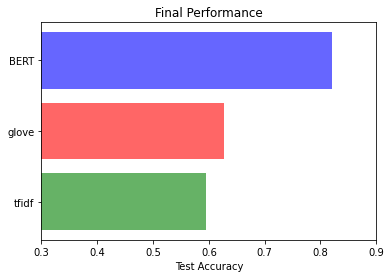

In [ ]:
# Plot to compare Tf-idf, glove and BERT
performance = [0.5956, 0.6272, 0.8212]
models = ['tfidf', 'glove', 'BERT']

plt.barh(models, performance, color=['green', 'red', 'blue'], alpha=0.6)
plt.xlim([0.3,0.9])
plt.xlabel('Test Accuracy')
plt.title('Final Performance')
plt.savefig('allmodels.png')
plt.show()